In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
from mpl_toolkits.mplot3d import Axes3D

import pickle
from scipy import stats

import statsmodels.formula.api as sm

In [6]:
data = dict()

files = ['PCECC96', 'WILL5000INDFC','GDPDEF','TB3MS']

for i in files:
    data[i] = pd.read_csv(i+'.csv')
    data[i]['DATE'] = pd.to_datetime(data[i]['DATE'])
    data[i] = data[i].set_index('DATE')

[data[i][i] for i in files]
dfrm = pd.concat([data[i][i] for i in files], axis=1, join='inner')
dfrm = dfrm.reset_index()

dfrm.columns = ['date', 'Ct', 'PMt', 'GDPDef', 'rfn']

for i in ['Ct', 'PMt', 'GDPDef', 'rfn' ]: #, 'qt','year'
    dfrm[i] = pd.to_numeric(dfrm[i])

#Set Inflation Rate, Rf real return on quarterly basis, Market real return net
dfrm['Infl'] = dfrm.GDPDef.pct_change()
dfrm['rfqr'] = dfrm.rfn/(4*100) - dfrm.Infl
dfrm['Rt'] = dfrm.PMt.pct_change() - dfrm.Infl + 1
dfrm['mt'] = .99* (dfrm.Ct.pct_change()+1)**(-6)

# Set time components (just informative)
dfrm['qt'] = dfrm['date'].dt.quarter
dfrm['year'] = dfrm['date'].dt.year


,date,Ct,PMt,GDPDef,rfn,Infl,rfqr,Rt,mt,qt,year
188,2018-04-01,12909.192,126.711094,110.281,1.840000,0.008468,-0.003868,0.990641,0.933292,2,2018
189,2018-07-01,13019.802,134.328571,110.767,2.040000,0.004407,0.000693,1.055710,0.940596,3,2018
190,2018-10-01,13066.302,126.443492,111.256,2.316667,0.004415,0.001377,0.936885,0.969048,4,2018
191,2019-01-01,13103.317,128.690492,111.473,2.386667,0.001950,0.004016,1.015820,0.973338,1,2019
192,2019-04-01,13241.083,136.506508,112.164,2.300000,0.006199,-0.000449,1.054536,0.929783,2,2019


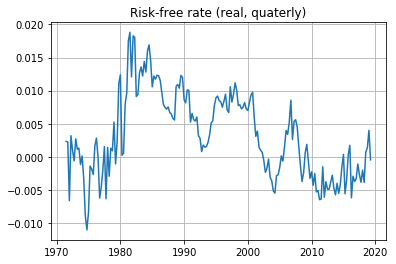

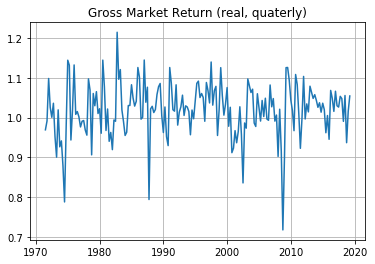

In [3]:
plt.figure()
plt.plot(dfrm.date, dfrm.rfqr)
plt.grid()
plt.title('Risk-free rate (real, quaterly)')
plt.figure()
plt.plot(dfrm.date, dfrm.Rt)
plt.grid()
plt.title('Gross Market Return (real, quaterly)')
dfrm.tail()

In [13]:
rf = dfrm.rfqr.tail(1)
print(rf *100)

192   -0.044881
Name: rfqr, dtype: float64


In [42]:
def capm_mkt(gamma,params):
    #unpack 
    dfrm, beta = params
    # get the S.D.F.
    dfrm['mt'] = beta* (dfrm.Ct.pct_change()+1)**(-gamma)
    mt = dfrm.mt.dropna()
    Rt = dfrm.Rt.dropna()
    covRtmt = np.cov(Rt,mt)[0,1]
    EtRt = np.mean(Rt)
    Etmt = np.mean(mt)
    # get the asset pricing equation
    ap = covRtmt + EtRt*Etmt - 1
    return ap

def capm_rf(gamma,params):
    #unpack 
    dfrm, beta = params
    # get the S.D.F.
    dfrm['mt'] = beta* (dfrm.Ct.pct_change()+1)**(-gamma)
    #set the real r.f. interest rate to the average over the observed period
    rf = np.mean(dfrm.rfqr.dropna())
    mt = dfrm.mt.dropna()
    Etmt = np.mean(mt)
    # get the asset pricing equation
    ap = 1/Etmt - 1 - rf
    return ap

def capm(unknowns,dfrm):
    ap = np.zeros(2)
    #unpack
    (gamma, beta) = unknowns
    # get the S.D.F.
    temp = dfrm.Ct.pct_change()+1
    dfrm['mt'] = beta* (dfrm.Ct.pct_change()+1)**(-gamma)
    mt = dfrm.mt.dropna()
    Rt = dfrm.Rt.dropna()
    rf = np.mean(dfrm.rfqr.dropna())
    
    covRtmt = np.cov(Rt,mt)[0,1]
    EtRt = np.mean(Rt)
    Etmt = np.mean(mt)
    # get the asset pricing equation
    ap[0] = covRtmt + EtRt*Etmt - 1
    ap[1] = 1/Etmt - 1 - rf
   
    return ap

def capm_gmm(theta,W,dfrm):
    # GMM estimation of gamma and beta from the intertemporal asset pricing model. Hansen, Singleton style 
    g = np.zeros(2)
    #unpack
    (gamma, beta) = theta
    # get the S.D.F.
    dfrm['mt'] = beta* (dfrm.Ct.pct_change()+1)**(-gamma)
    mt = dfrm.mt.dropna()
    Rt = dfrm.Rt.dropna()
    #rf = np.mean(dfrm.rfqr.dropna())

    g[0] = np.mean( beta* mt*(Rt) -1 )
    g[1] = np.mean( beta* mt *(1+ dfrm.rfqr) -1)
    
    # the "error" 
    Q = g.reshape(1, len(g))@W@g.reshape(len(g),1)
    
    return float(Q)

### 2.5.1 Calculate the sample analogs of the expected values and covariance in (5)

In [18]:
# 2.5.1

gamma_guess = 10.
# pack params
beta = .99
params = dfrm, beta

Fn = lambda gamma: capm_mkt(gamma,params)
root = opt.root(Fn, gamma_guess, tol=.00001)
print(root)
print('gamma =',root.x)



    fjac: array([[-1.]])
     fun: 0.0
 message: 'The solution converged.'
    nfev: 7
     qtf: array([-1.47532431e-10])
       r: array([0.0075184])
  status: 1
 success: True
       x: array([1.17571888])
gamma = [1.17571888]


### 2.5.2. How would you determine if this parameter is reasonable?

$\gamma$ seems too low to accomodate actual risk preferecnes of people $\implies$ **the equity premium puzzle** 

### 2.5.3. Consider the moment restriction given in equation (7)


In [19]:
# 2.5.3
beta = .99
gamma_guess = 10

Fn = lambda gamma: capm_rf(gamma,params)
root = opt.broyden1(Fn, gamma_guess)
print(root)
print('gamma =',root)


-0.9169230585370297
gamma = -0.9169230585370297


Much lower estimate. $\implies$ Equity premium puzzle

### 2.5.4. Finally, estimate 𝛽 and 𝛾 using both equation (5) and equation (7).

In [66]:
# GMM
W = np.eye(2)
theta_guess = [10, 0.5]
Fn = lambda theta: capm_gmm(theta,W,dfrm)
# constraint beta < 1 
theta_0 = opt.minimize(Fn, x0=(theta_guess))
print(f'gamma = {theta_0.x[0]:.6}')
print(f'beta = {theta_0.x[1]:.6f}')

gamma = 9.99802
beta = 1.031357


$\implies$ The discount factor $\beta$ above 1 is unrealistic and the risk aversion factor $\gamma$ is rather high. Could be the result of negative interest rates and the equity premium puzzle.  
 

Text(0.5, 0, 'Asset Pricing Fn')

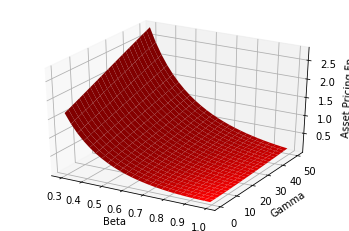

In [18]:
gridPoints = 25
beta_grid = np.linspace(.3,.99,gridPoints)
gamma_grid= np.linspace(.3,50,gridPoints)
ap = np.zeros([gridPoints,gridPoints])

for iG, gamma in enumerate(gamma_grid):
    for iB, beta in enumerate(beta_grid):
        unknowns = [gamma,beta]
        ap[iG,iB] = sum(capm(unknowns,dfrm))
        
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
Bax, Gax = np.meshgrid(beta_grid,gamma_grid)
ax.plot_surface(Bax, Gax, ap, color='r')
ax.set_xlabel('Beta')
ax.set_ylabel('Gamma')
ax.set_zlabel('Asset Pricing Fn')



## Problem 3.5 : The Kyle Model

+ First unpicle and process the data: 

In [2]:
# load data from pickle files
AAPL = pickle.load(open("AAPL", "rb"))
C = pickle.load(open("C", "rb"))
GBX = pickle.load(open("GBX", "rb"))
SPY = pickle.load(open("SPY", "rb"))
THO = pickle.load(open("THO", "rb"))

### Part 1

In [3]:
class orderbook:    
    def __init__(self, orderbook):
        
        self.timestamp = orderbook[0]
        orderbook = pd.DataFrame.from_dict(orderbook[1], orient='index')
        orderbook.drop(columns=[2, 3], inplace=True)
        orderbook.reset_index(inplace=True)
        orderbook.columns = ['price', 'quantity', 'side']
        orderbook.sort_values('price', inplace=True)
        # sort buy & sell orders : 
        buy = orderbook[orderbook.side == 'B'].sort_values('price', ascending=False)
        buy['y'] = -buy['quantity'].cumsum()  # buying = selling negative assets        
        sell = orderbook[orderbook.side == 'S'].sort_values('price', ascending=True)  
        sell['y'] = sell['quantity'].cumsum()
        
        orderbook = pd.concat([buy, sell])
        orderbook.sort_values('price', inplace=True)
        self.orderbook = orderbook
        p0 = self.find_p0()  # get midpoint of BBO
        
        #dataframe with data within 50% of BBO
        self.orderbook50 = orderbook[(orderbook.price <= p0 * 1.5)  & (orderbook.price >= p0 * 0.5)]
        
        #dataframe with data within 5% of BBO
        self.orderbook5 = orderbook[(orderbook.price <= p0 * 1.05) & (orderbook.price >= p0 * 0.95)]
        
    def plot(self):
        '''plot data'''
        orderbook = self.orderbook
        plt.figure(figsize=(4,2))
        plt.plot(orderbook.price, orderbook.y, label='Orderbook')
        plt.grid()
        plt.xlabel('price')
        plt.ylabel('quantity')
        plt.legend()
        

    def plot50(self):
        '''plot data within 50% of BBO'''
        orderbook50 = self.orderbook50
        plt.plot(orderbook50.price, orderbook50.y, label='Orderbook') 
        plt.xlabel('price')
        plt.ylabel('quantity')
        plt.legend()

    def OLS(self, orderbook):
        '''regress cumulative sum on price'''
        result = sm.ols(formula="y ~ price", data=orderbook).fit()  
        return result.params

    def plot_estimates(self):
        orderbook5 = self.orderbook5
        orderbook50 = self.orderbook50
        ols_params = self.OLS(orderbook5)  # fit linear regression to data within 5% of BBO
        gamma = ols_params[0]
        beta = ols_params[1]
        estimate = gamma + beta * orderbook50.price
        plt.plot(orderbook50.price, estimate, label='Estimate')
        plt.xlim(orderbook50.price.min(), orderbook50.price.max())
        plt.ylim(orderbook50.y.min() * 1.1, orderbook50.y.max() * 1.1)
        plt.xlabel('price')
        plt.ylabel('quantity')
        plt.legend()

    def find_p0(self):
        orderbook = self.orderbook
        best_offer = orderbook[orderbook.side == 'S'].price.min()
        best_bid = orderbook[orderbook.side == 'B'].price.max()
        return (best_offer + best_bid) / 2  # actual midpoint of BBO    
    
    def find_p0_5(self):
        '''find p for data within 5% of BBO'''     
        orderbook = self.orderbook
        p0 = self.find_p0()
        best_offer = orderbook[(orderbook.side == 'S') & (orderbook.price <= p0 * 1.05)& (orderbook.price >= p0 * 0.95)].price.min()
        best_bid = orderbook[(orderbook.side == 'B')& (orderbook.price <= p0 * 1.05)& (orderbook.price >= p0 * 0.95)].price.max()
        return (best_offer + best_bid) / 2  # actual midpoint of BBO

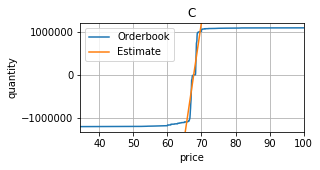

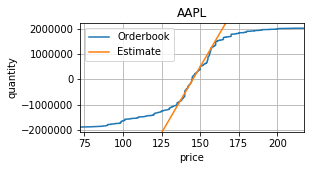

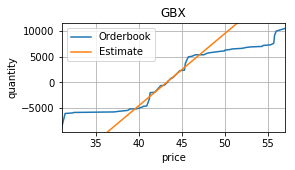

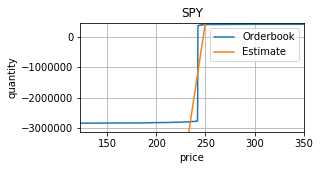

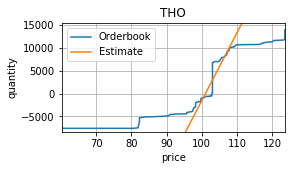

In [4]:
stocks = (C,AAPL,GBX,SPY,THO)
stock_names = ("C","AAPL","GBX","SPY","THO")

# Using all data 
for iS, (stock, name) in enumerate(zip(stocks, stock_names)):
    stock = orderbook(stock[0])
    stock.plot()
    stock.plot_estimates()
    plt.title(name) 
    plt.show()

In [12]:
class ticker:
    
    def __init__(self, orderbooks):
        self.orderbooks = [orderbook(Orderbook) for Orderbook in orderbooks]  # index over all orderbook
        self.timestamps = [orderbook.timestamp for orderbook in self.orderbooks]  # all timestamps
        #self.orderbooks5 = [orderbook(Orderbook).orderbook5 for Orderbook in orderbooks]
    
    def estimate_beta(self):
        '''computes estimates of β for each orderbook
        uses data within 5% of the BBO'''
        orderbooks = self.orderbooks
        beta = np.array([orderbook.OLS(orderbook.orderbook5)[1] for orderbook in orderbooks]) 
        return beta
    
    def estimate_gamma(self):
        '''computes estimates of γ for each orderbook
        uses data within 5% of the BBO'''
        orderbooks = self.orderbooks
        gamma = np.array([orderbook.OLS(orderbook.orderbook5)[0] for orderbook in orderbooks])  
        return gamma
    
    def plot_beta(self):
        beta = self.estimate_beta()
        plt.figure(figsize=(4,2))
        plt.plot(self.timestamps, beta)
        plt.grid()        
        plt.xlabel('timestamp')
        plt.ylabel('Noise/Signal Ratio')
        
    def plot_p0_estimates(self):
        beta = self.estimate_beta()
        gamma = self.estimate_gamma()
        p0 = - gamma / beta  # estimate BBO
        plt.plot(self.timestamps, p0, label='Estimated p_0')
        plt.xlabel('Seconds after midnight')
        plt.ylabel('BB0')
        plt.legend()
    
    def plot_p0(self):
        '''plots'''
        orderbooks = self.orderbooks
        p0 = np.array([orderbook.find_p0() for orderbook in orderbooks]) 
        plt.plot(self.timestamps, p0, label='data BBO, all data')
        plt.xlabel('timestamp')
        plt.ylabel('BBO')
        plt.legend()
        
    def plot_p0_5(self):
        '''plots actual p0 for data within 5% of BBO'''
        orderbooks = self.orderbooks
        p0 = np.array([orderbook.find_p0_5() for orderbook in orderbooks])                 
        plt.plot(self.timestamps, p0, label='data BBO, data within 5% of BBO')
        plt.xlabel('timestamp')
        plt.ylabel('BBO')
        plt.legend()

### Part 2

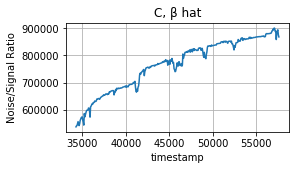

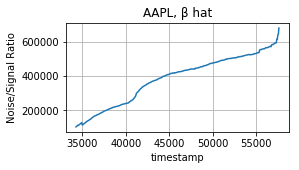

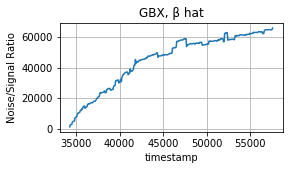

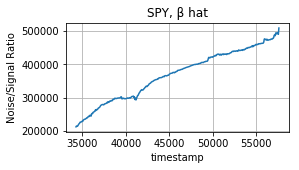

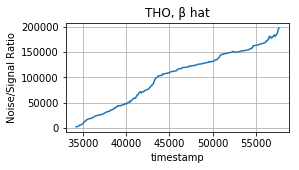

In [6]:
for iS, (stock, name) in enumerate(zip(stocks, stock_names)):
    stock = ticker(stock)
    stock.plot_beta()
    plt.title(name + ", β hat")
    plt.show()


### Part 3

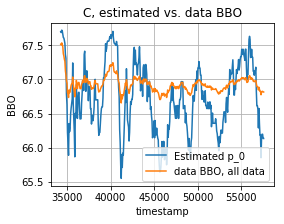

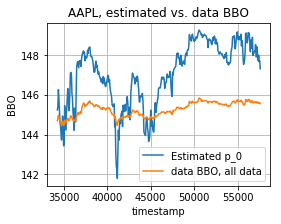

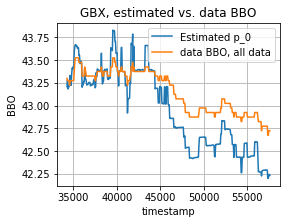

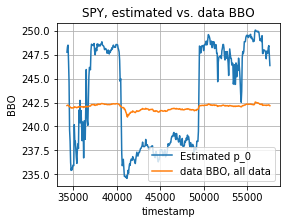

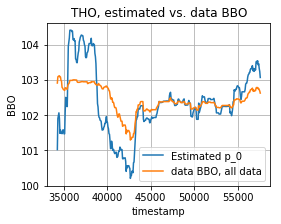

In [14]:
# Using all data 
for iS, (stock, name) in enumerate(zip(stocks, stock_names)):
    stock = ticker(stock)
    plt.figure(figsize=(4,3))
    stock.plot_p0_estimates()
    stock.plot_p0()
    plt.title(name + ', estimated vs. data BBO')        
    plt.grid()                

    plt.show()
